In [1]:
%matplotlib inline

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tensorboardX import SummaryWriter

plt.ion()   # interactive mode

Load Data
---------


In [24]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images


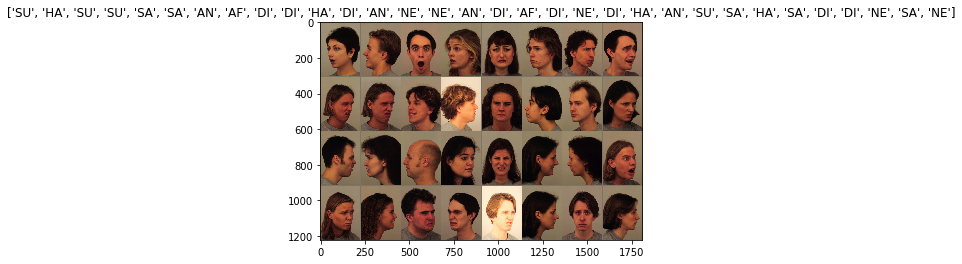

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [46]:
def train_model(model, criterion, optimizer, scheduler, writer=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            

            writer.add_scalar(phase+"/loss", epoch_loss, epoch)
            writer.add_scalar(phase+"/acc", epoch_acc, epoch)


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [17]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train and evaluate



In [25]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.6948 Acc: 0.3889
val Loss: 1.0263 Acc: 0.6883

Epoch 1/24
----------
train Loss: 1.3816 Acc: 0.4949
val Loss: 0.9467 Acc: 0.6842

Epoch 2/24
----------
train Loss: 1.2631 Acc: 0.5397
val Loss: 0.6522 Acc: 0.7814

Epoch 3/24
----------
train Loss: 1.1248 Acc: 0.5840
val Loss: 0.6578 Acc: 0.7976

Epoch 4/24
----------
train Loss: 0.9021 Acc: 0.6682
val Loss: 0.3525 Acc: 0.8907

Epoch 5/24
----------
train Loss: 0.8678 Acc: 0.6756
val Loss: 0.2926 Acc: 0.8988

Epoch 6/24
----------
train Loss: 0.8390 Acc: 0.6859
val Loss: 0.2664 Acc: 0.8988

Epoch 7/24
----------
train Loss: 0.8197 Acc: 0.6975
val Loss: 0.2461 Acc: 0.9109

Epoch 8/24
----------
train Loss: 0.8003 Acc: 0.7089
val Loss: 0.2253 Acc: 0.9109

Epoch 9/24
----------
train Loss: 0.7926 Acc: 0.7127
val Loss: 0.2199 Acc: 0.9231

Epoch 10/24
----------
train Loss: 0.7614 Acc: 0.7188
val Loss: 0.2588 Acc: 0.9028

Epoch 11/24
----------
train Loss: 0.7617 Acc: 0.7166
val Loss: 0.2208 Acc: 0.9271

Ep

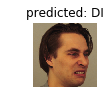

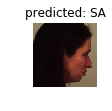

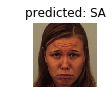

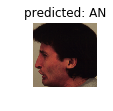

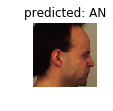

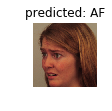

In [32]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------




In [33]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

In [34]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.1020 Acc: 0.2030
val Loss: 2.0674 Acc: 0.2267

Epoch 1/24
----------
train Loss: 1.9915 Acc: 0.2614
val Loss: 2.0210 Acc: 0.2672

Epoch 2/24
----------
train Loss: 1.9814 Acc: 0.2746
val Loss: 2.0085 Acc: 0.3198

Epoch 3/24
----------
train Loss: 1.9661 Acc: 0.2823
val Loss: 1.9441 Acc: 0.3482

Epoch 4/24
----------
train Loss: 1.9763 Acc: 0.2804
val Loss: 1.5151 Acc: 0.3927

Epoch 5/24
----------
train Loss: 1.9844 Acc: 0.2840
val Loss: 1.6480 Acc: 0.3887

Epoch 6/24
----------
train Loss: 1.9648 Acc: 0.2905
val Loss: 1.6670 Acc: 0.3765

Epoch 7/24
----------
train Loss: 1.7544 Acc: 0.3238
val Loss: 1.5433 Acc: 0.4332

Epoch 8/24
----------
train Loss: 1.7109 Acc: 0.3406
val Loss: 1.5086 Acc: 0.4291

Epoch 9/24
----------
train Loss: 1.7051 Acc: 0.3449
val Loss: 1.4916 Acc: 0.4170

Epoch 10/24
----------
train Loss: 1.7109 Acc: 0.3429
val Loss: 1.5555 Acc: 0.4049

Epoch 11/24
----------
train Loss: 1.6765 Acc: 0.3522
val Loss: 1.5178 Acc: 0.4211

Ep

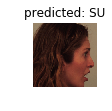

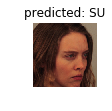

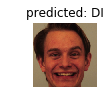

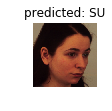

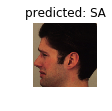

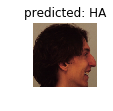

In [38]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Try last and fully connected layer

In [48]:
for param in model_conv.parameters():
    param.requires_grad = True


optimizer_conv = optim.SGD(list(model_conv.fc.parameters())+list(model_conv.layer4.parameters()), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

writer = SummaryWriter('./logs/resnet18_last2layers')

In [49]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, writer, num_epochs=35)

Epoch 0/34
----------
train Loss: 1.2917 Acc: 0.5235
val Loss: 0.6721 Acc: 0.7692

Epoch 1/34
----------
train Loss: 1.1871 Acc: 0.5558
val Loss: 0.6221 Acc: 0.7692

Epoch 2/34
----------
train Loss: 1.1643 Acc: 0.5693
val Loss: 0.5996 Acc: 0.7652

Epoch 3/34
----------
train Loss: 1.0656 Acc: 0.6042
val Loss: 0.6036 Acc: 0.7611

Epoch 4/34
----------
train Loss: 1.0504 Acc: 0.6018
val Loss: 0.7087 Acc: 0.7611

Epoch 5/34
----------
train Loss: 1.0513 Acc: 0.6188
val Loss: 0.7775 Acc: 0.7571

Epoch 6/34
----------
train Loss: 1.0089 Acc: 0.6235
val Loss: 0.5395 Acc: 0.8178

Epoch 7/34
----------
train Loss: 0.8872 Acc: 0.6758
val Loss: 0.3662 Acc: 0.8583

Epoch 8/34
----------
train Loss: 0.8396 Acc: 0.6859
val Loss: 0.3854 Acc: 0.8664

Epoch 9/34
----------
train Loss: 0.8173 Acc: 0.6893
val Loss: 0.3994 Acc: 0.8543

Epoch 10/34
----------
train Loss: 0.8406 Acc: 0.6859
val Loss: 0.3550 Acc: 0.8583

Epoch 11/34
----------
train Loss: 0.8244 Acc: 0.6934
val Loss: 0.3503 Acc: 0.8664

Ep